# Example analysis of the modified 01 chaos test
### see Gottwald and Merbourne 2009
https://epubs.siam.org/doi/abs/10.1137/080718851


In [35]:
import numpy as np
import matplotlib.pyplot as plt

We first define the logistic equation and use the parameters as defined in the paper

In [36]:
def equation (r, seed, iterations):
    """
    Outputs the time series plot of the logistic equation given some parameters

    Arguments:
    r            -- growth rate of population
    seed         -- the seed of this function x0
    iterations   -- number of iterations to calculate

    Output:
    out      -- values of X over time given initial condition
    
    """
    
    # initialize output and insert seed
    out = []
    out.append(seed)
    
    x = seed
    # iterate over iterations and calculate new y
    for i in range(iterations):
        # x as Population next year
        x = r*x*(1-x)
        #x = (r*x)+3
        out.append(x)
    return(out)     

This is the figure from Gottwald and Melbourne (2009) we orient on. 
It shows different values of K (y-axis) depended on the selection of the parameter r of the logistic map
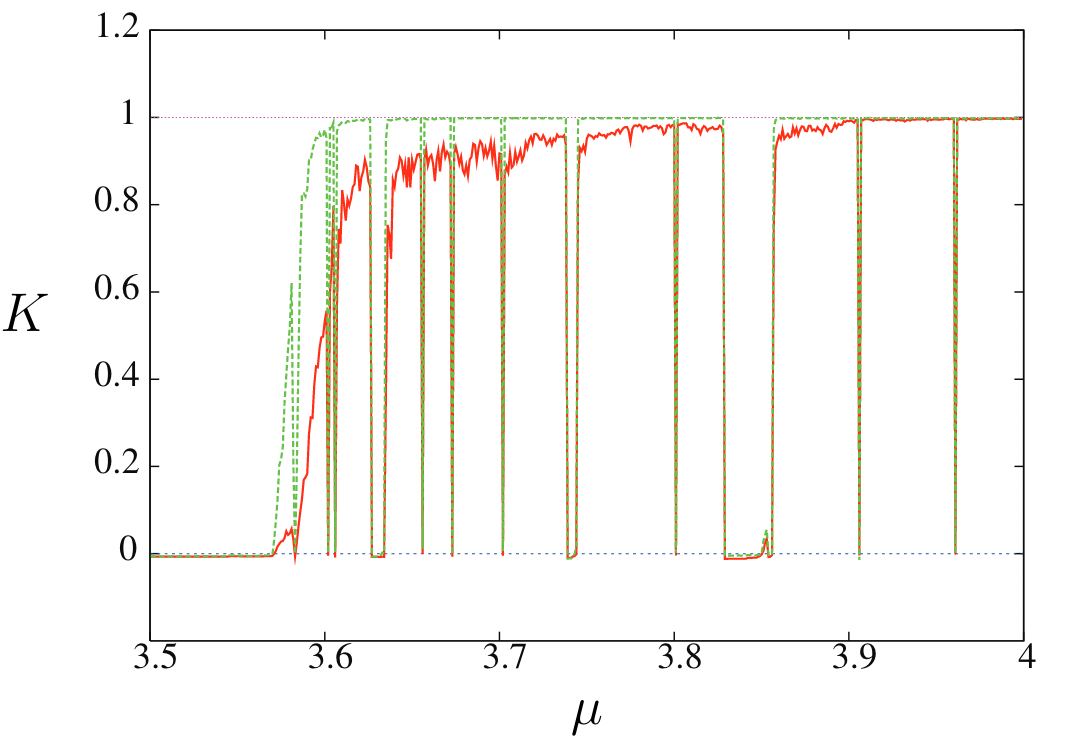

In [37]:
# Define parameters and initial condition

#r = 3.5 # should lead to a close to 0 K
r = 3.85 # should lead to a close to 0 K
#r = 3.81 # should lead to a K arounf .4
#r = 3.9 # should lead to a K around .6

seed =0.0001
iterations = 21000
transient = 20000

In [38]:
# calculate time-series of the logistic map and define output after transient
out = equation(r, seed, iterations)
Obs = out[transient+1:]  # This is our observerd Time Series

Text(0.5, 1.0, 'Observed time series from logistic map')

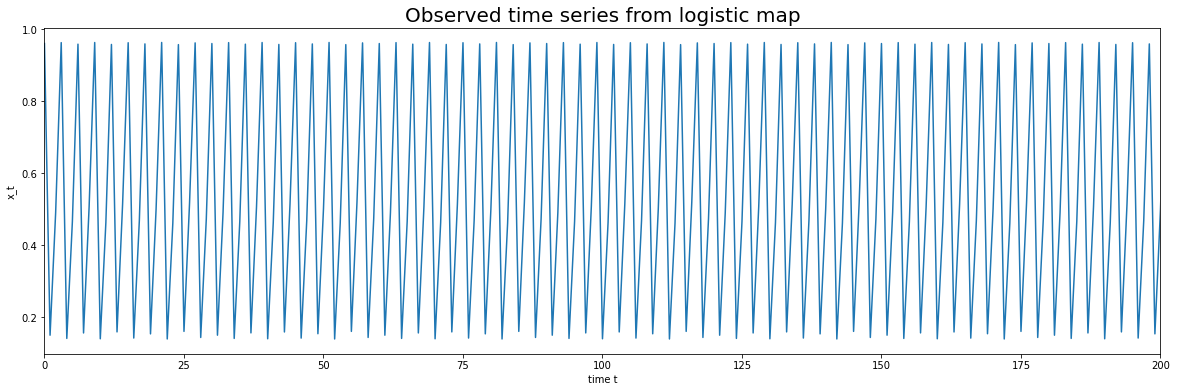

In [39]:
plt.figure(figsize = (20, 6))
plt.plot(out[transient:])
plt.xlabel("time t")
plt.ylabel("x_t")
plt.xlim(0,200)
plt.title('Observed time series from logistic map', fontsize =20)

define parameter c. In the paper, c is radomly reinitiated 100 times. 

In [40]:
c = np.random.uniform(low=0, high=2*np.pi)
c

2.113869774412424

## Define translation variables p(n) and q(n)

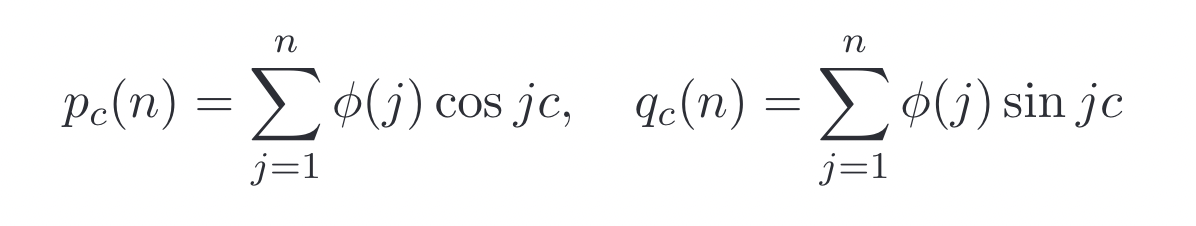

In [41]:
def get_trans_var(Obs,c):
    p = []
    q = []
    for t in range(len(Obs)):
        p_tmp = np.sum(Obs[:t]*np.cos(np.arange(0,t,1))*c)
        q_tmp = np.sum(Obs[:t]*np.sin(np.arange(0,t,1))*c)
        p.append(p_tmp)
        q.append(q_tmp)
    return (np.array(p), np.array(q))

def p_q_Toker(Obs,c):
    j = np.arange(len(Obs))
    p = np.cumsum(Obs * np.cos(j*c));
    q = np.cumsum(Obs * np.sin(j*c));
    return (np.array(p), np.array(q))

    

In [42]:
ps, qs = get_trans_var(Obs, c)
pt, qt = p_q_Toker(Obs, c)

### Explore p and q
Figure from Gottwald and Melbourne (2009)shows typical plots for chaotic and non-chaotic systems


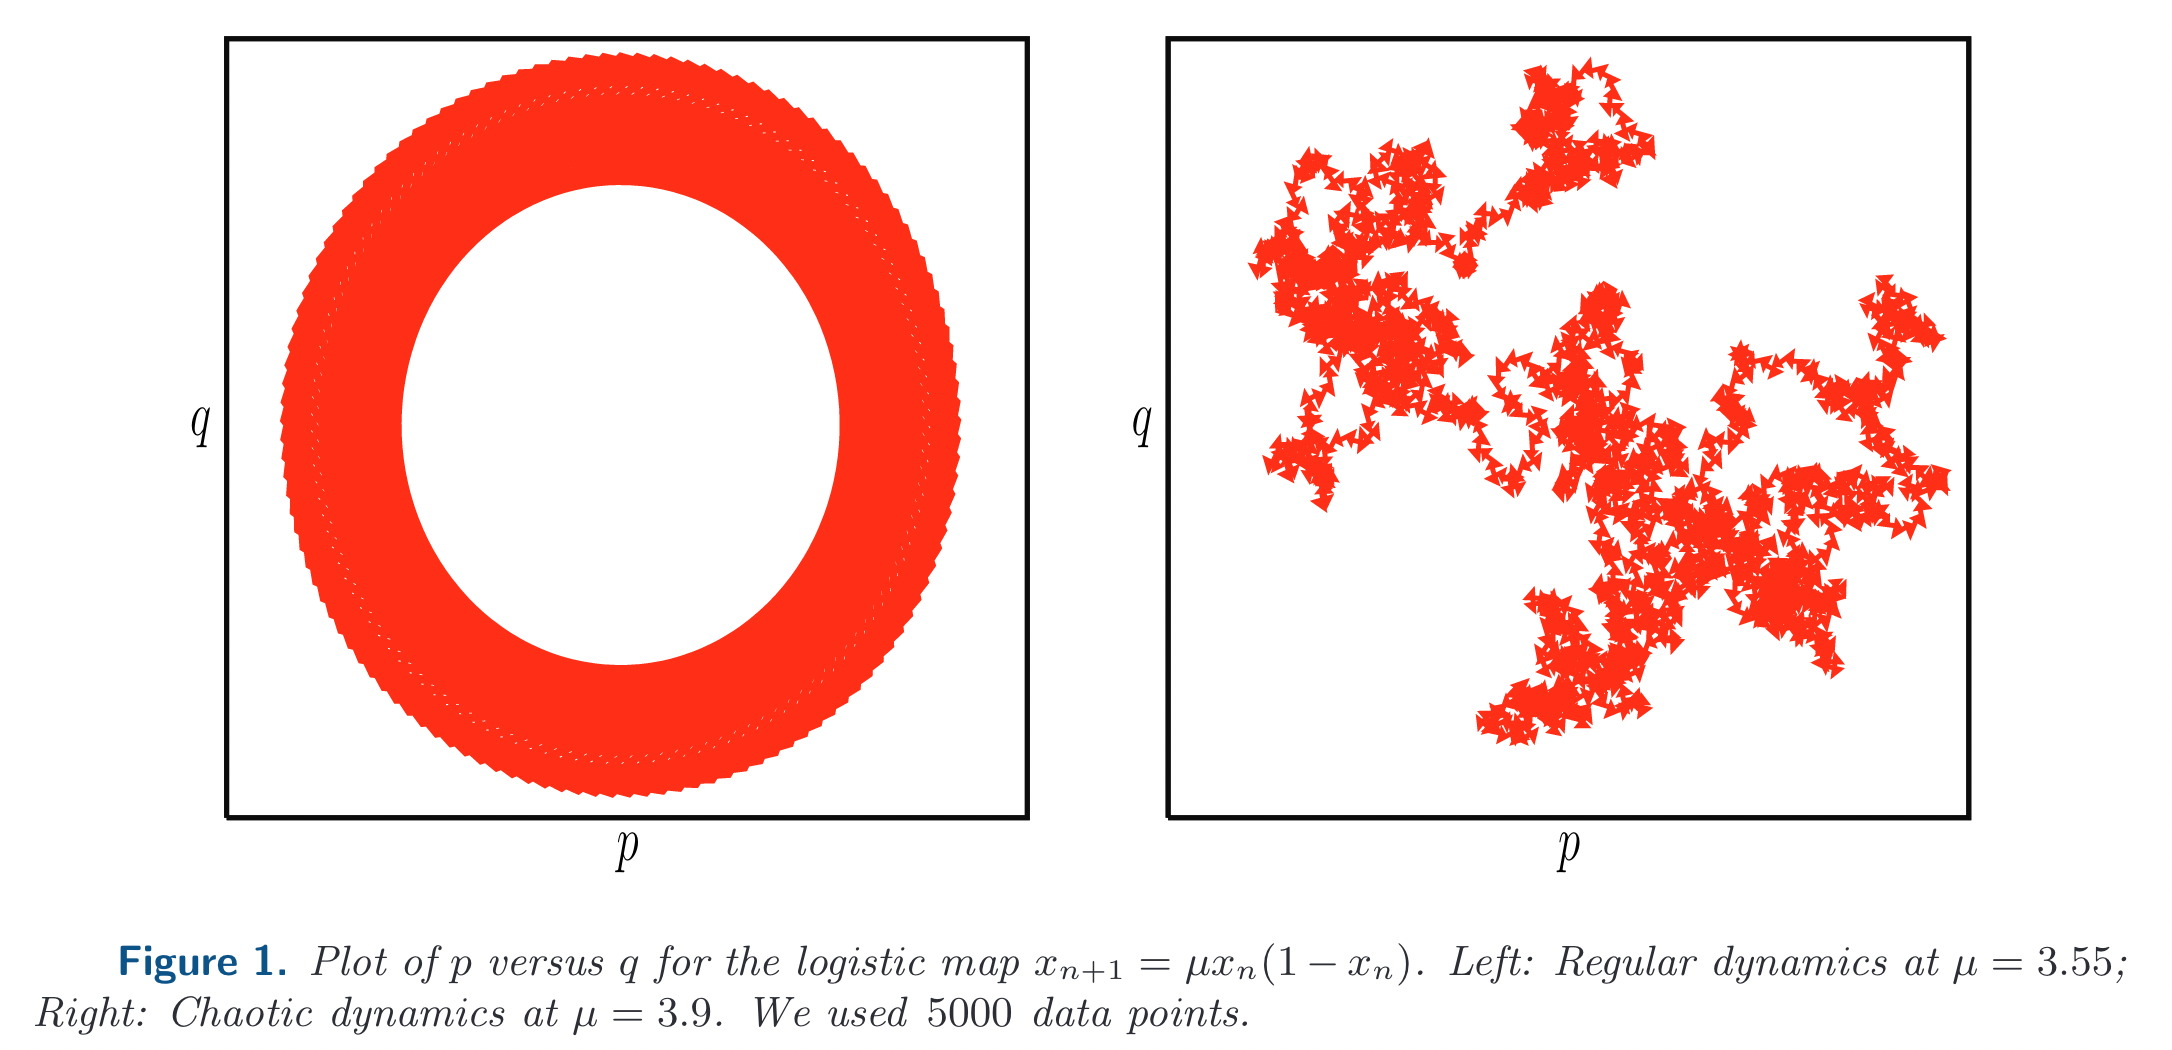

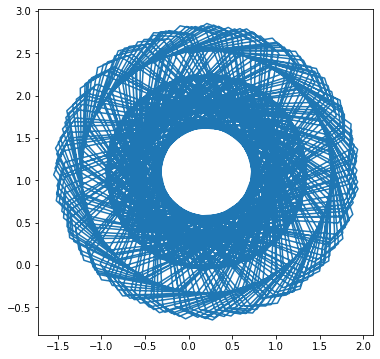

In [43]:
plt.figure(figsize = (6,6))
plt.plot(ps,qs)

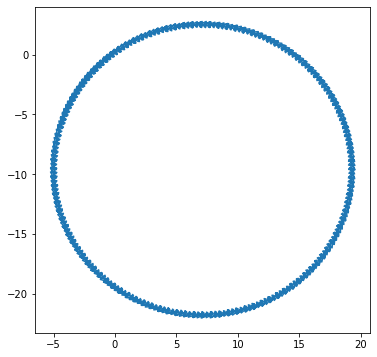

In [44]:
plt.figure(figsize = (6,6))
plt.plot(pt,qt)

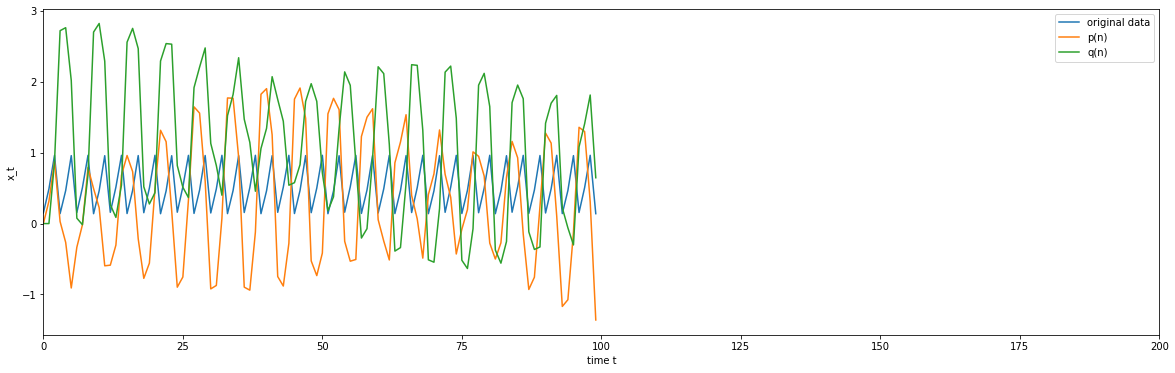

In [45]:
t = 100
plt.figure(figsize = (20, 6))
plt.plot(Obs[:t])
plt.plot(ps[:t])
plt.plot(qs[:t])
plt.xlabel("time t")
plt.ylabel("x_t")
#plt.ylim(0,1)
plt.xlim(0,200)
plt.legend(['original data', 'p(n)','q(n)'])

## Calculation of Mean Square displacement
The MSD looks at the displacement of the function over time with a variable delay (i.e. how much one particle moves in average with a certain delay).

"If the behaviour of p(t) is Brownian, i.e. the underlying dynamics is chaotic, then M (t) grows linearly in time; if the behaviour is bounded, i.e. the underlying dynamics is nonchaotic, then M (t) is bounded." Gottwald and Melbourne (2013)


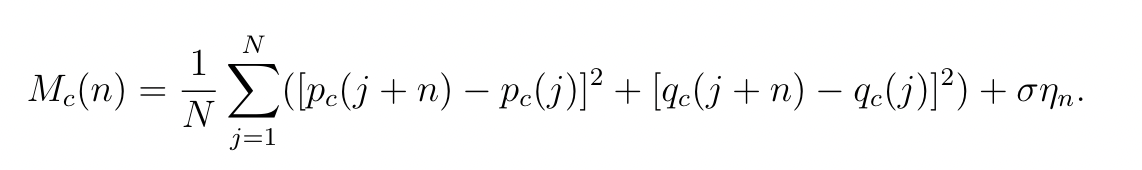

, where η is a uniformly distributed random variable between [− 0.5, 0.5 ] and σ controls the amplitude of the added random variable ηn

In [46]:
sigma = 0.5

In [47]:
def get_MSD(ps, qs,sigma):
    MSD = []
    for t in range(len(Obs)):
        tmp = []
        for j in range(len(Obs)-t):
            tmp.append(((ps[j+t]-ps[j])**2)+((qs[j+t]-qs[j])**2))
        eta = np.random.uniform(low=-0.5, high=0.5)
        MSD.append(np.mean(tmp)+sigma+eta)
    return MSD

In [48]:
def get_MSD_Toker(ps, qs,sigma):
    N = len(ps)
    M = np.zeros(int(round(N / 10)))
    for n in range(int(round(N / 10))):
        # Calculate the (time-averaged) mean-square displacement,
        # subtracting a correction term (Gottwald & Melbourne, 2009)
        # and adding a noise term scaled by sigma (Dawes & Freeland, 2008)
        M[n]=(np.mean((ps[n+1:N] - ps[1:N-n])**2 + (qs[n+1:N]-qs[1:N-n])**2)
            -np.mean(Obs)**2*(1-np.cos(n*c))/(1-np.cos(c))+sigma*(np.random.random()-.5))
    return M


In [49]:
MSDs = get_MSD(ps,qs,sigma)
MSD_Toker = get_MSD_Toker(ps,qs,sigma)

Text(0, 0.5, 'motion')

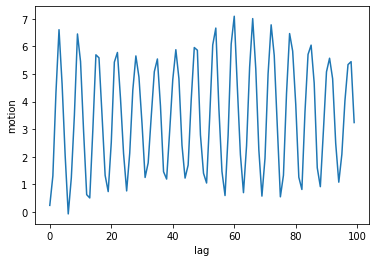

In [50]:
plt.plot(MSD_Toker)
plt.xlabel('lag')
plt.ylabel('motion')

Text(0, 0.5, 'motion')

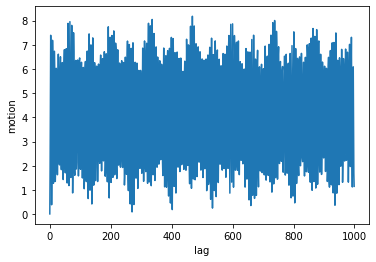

In [51]:
plt.plot(MSDs)
plt.xlabel('lag')
plt.ylabel('motion')

### Calculation of K

Now we can calculate K which is the slope (i.e. the growth rate) of the MSD. In Toker et al 2022, this is done by a correlation. 
K approaches 1 for a more chaotic system.
"The test is now that K close to zero signifies regular dynamics and K close to 1 implies chaotic dynamics." Gottwald Melbourne 2004

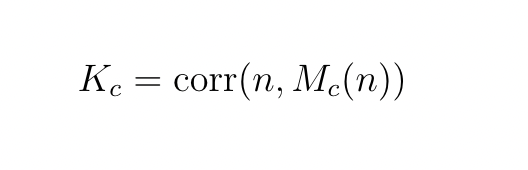

In [52]:
def get_K(MSDs):
    # They do not specify this in the paper, but the code is using the same value here
    N1 = int(len(Obs)/10)
    t = np.arange(N1)
    K = abs(np.corrcoef(MSDs[:N1], t)[0,1])
    return K 

In [53]:
get_K(MSDs)

0.09622032553214051

In the paper, they choose 100 different values for c between 0 and 2Pi, computing K for each choice of c. Then we take the median value of K. 
(They do not take the average of K, since when c does fail it can fail quite badly.)

